In [312]:
# Imports
import numpy as np
import pandas as pd
import sklearn.metrics as skm
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Define your path
path = "/Users/joche/Documents/GitHub/GVAR_modeling/"

# Data preperation

In [123]:
# Import all data for different variables
variable_list_raw = ['GDP', 'CPI','long_int','short_int','exch_rate','CPI_lag']
df_variable_raw = pd.read_excel(path + "Variable_data.xlsx",index_col=0, sheet_name=variable_list_raw)

# To prevent LinAlg errors:
df_variable_raw['exch_rate'].loc["United States"] += np.random.normal(0,0.01,df_variable_raw['exch_rate'].shape[1])

# Make a dictionary for all variables
df_variable = {}

# Transformating the data
df_variable['GDP'] = np.log(df_variable_raw['GDP'] / df_variable_raw['CPI'])
df_variable['inf_rate'] = np.log(df_variable_raw['CPI']) - np.log(df_variable_raw['CPI_lag'])
df_variable['long_int'] = 1/12 * np.log(1+ df_variable_raw['long_int'])
df_variable['short_int'] = 1/12 * np.log(1+ df_variable_raw['short_int'])
df_variable['exch_rate'] = np.log(df_variable_raw['exch_rate']) - np.log(df_variable_raw['CPI'])

In [124]:
# Example of the data of GDP
df_variable['GDP']

,1996-01-01,1996-02-01,1996-03-01,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
GDP,,,,,,,,,,,,,,,,,,,,,
Australia,7.111526,7.109974,7.109045,7.108639,7.108802,7.109724,7.111451,7.113886,7.117012,7.120009,...,7.245003,7.242691,7.240865,7.237977,7.234116,7.229641,7.224830,7.220180,7.215890,7.212375
Brazil,7.298547,7.265720,7.255515,7.248464,7.248838,7.252285,7.254880,7.258204,7.255993,7.247954,...,6.245628,6.238087,6.235718,6.230620,6.238351,6.242242,6.244860,6.238253,6.232938,6.225192
Canada,7.182050,7.181960,7.179124,7.179272,7.178639,7.181598,7.184533,7.187242,7.188597,7.188877,...,7.249739,7.246856,7.236032,7.232001,7.232621,7.237186,7.237162,7.230052,7.228093,7.232778
France,7.380348,7.374446,7.367507,7.366746,7.365897,7.368816,7.372472,7.375927,7.374124,7.372342,...,7.389731,7.387556,7.382731,7.376268,7.373598,7.368834,7.374215,7.363898,7.361342,7.363840
Germany,7.682714,7.688150,7.695440,7.699543,7.700288,7.699928,7.699483,7.701185,7.704330,7.707481,...,7.624106,7.616684,7.606889,7.607831,7.605180,7.603438,7.586272,7.577714,7.571316,7.566637
Italy,7.396040,7.389030,7.383779,7.379578,7.376119,7.374964,7.376462,7.375475,7.373617,7.371353,...,7.043788,7.048628,7.044076,7.034828,7.031480,7.023761,7.020841,6.986684,6.981243,6.978765
Japan,12.850322,12.864937,12.870368,12.868049,12.867329,12.870474,12.871490,12.873739,12.872666,12.874797,...,12.959260,12.960084,12.961055,12.962100,12.956011,12.949845,12.943860,12.937610,12.938058,12.942606
Korea,13.774596,13.780142,13.781106,13.780902,13.780954,13.786446,13.787371,13.788933,13.793843,13.800024,...,14.099692,14.094856,14.090692,14.086429,14.082658,14.084086,14.080734,14.076859,14.075656,14.070829
New Zealand,5.010273,5.009471,5.010367,5.012259,5.014867,5.017504,5.019902,5.021249,5.021431,5.020249,...,5.200104,5.201987,5.205242,5.206727,5.206079,5.203146,5.198064,5.190857,5.181424,5.169673


In [133]:
# Define a list of all countries and variables (and a list of extended names for variables for plotting)
country_list = df_variable['GDP'].index.values
variable_list = np.array(['GDP', 'inf_rate','long_int','short_int','exch_rate'])
ext_variable_list = ['Real gross domestic product','Inflation rate','Long-term interest rate','Short-term interest rate','Real exchange rate']

# Define an empty dictionary
df = {}

# Loop over all countries and put their variable data in dictionary df
for country in country_list:
    country_collection = []
    
    for variable in variable_list:
        country_collection.append(df_variable[variable].loc[country])
    
    df[country] = pd.DataFrame(country_collection,index=variable_list)

In [134]:
# Example of the data of the United States
df['United States']

,1996-01-01,1996-02-01,1996-03-01,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
GDP,9.442539,9.449189,9.451437,9.452844,9.454810,9.457333,9.458181,9.459295,9.459754,9.460273,...,9.439093,9.433012,9.422873,9.411266,9.414238,9.417735,9.418474,9.416719,9.418875,9.421459
inf_rate,0.005949,0.003243,0.005055,0.003914,0.001951,0.000557,0.001946,0.001943,0.003183,0.003173,...,0.013285,0.005597,0.010951,0.013633,-0.000147,-0.000368,0.002206,0.004032,-0.001025,-0.003081
long_int,0.010751,0.010992,0.011676,0.012210,0.012748,0.012210,0.011929,0.012239,0.011951,0.012225,...,0.008018,0.008026,0.008185,0.008652,0.009011,0.008637,0.008884,0.009168,0.008907,0.008981
short_int,0.004375,0.004185,0.004296,0.004351,0.004351,0.004430,0.004485,0.004383,0.004470,0.004391,...,0.000606,0.000755,0.001101,0.001544,0.002058,0.002269,0.002633,0.003148,0.003636,0.003676
exch_rate,-4.261606,-4.260566,-4.271111,-4.279732,-4.272647,-4.294324,-4.285420,-4.288823,-4.273812,-4.273756,...,-4.888788,-4.896360,-4.905039,-4.914264,-4.914908,-4.909460,-4.909120,-4.917707,-4.914241,-4.906891


# Trade matrix

In [135]:
# Import all trading data
df_trade_raw = pd.read_excel(path + "Trade_statistics.xlsx",index_col=[0,1])

# Get a list of all years (data from 1993 until 2022)
year_list = df_trade_raw.columns

# Define an empty dictionary
df_trade_year = {} 

# Loop over all years and put the trade weights data of that year in dictionary df_trade_year
for year in year_list:
    country_collection = []
    
    for country in country_list:
        country_collection.append(df_trade_raw.loc[country, year] / np.sum(df_trade_raw.loc[country, year]))
    
    df_trade_year[year] = pd.DataFrame(country_collection,index=country_list)

In [136]:
# Example of the trade weights on the year 2000
df_trade_year[1995]

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
Australia,0.000000,0.008081,0.029534,0.018622,0.028224,0.032035,0.408060,0.149838,0.128363,0.016162,0.007361,0.061261,0.112460
Brazil,0.014308,0.000000,0.022046,0.049668,0.103230,0.081943,0.148355,0.039579,0.002160,0.012481,0.041942,0.063405,0.420883
Canada,0.004478,0.005239,0.000000,0.007410,0.013136,0.007351,0.049235,0.011243,0.000732,0.000910,0.002462,0.015392,0.882412
France,0.008250,0.009110,0.012133,0.000000,0.323878,0.176981,0.036100,0.012710,0.001613,0.006506,0.134842,0.169797,0.108080
Germany,0.016051,0.022073,0.012539,0.257852,0.000000,0.166854,0.057478,0.026723,0.002195,0.017488,0.076384,0.177586,0.166775
Italy,0.011544,0.023712,0.016093,0.228741,0.330302,0.000000,0.039992,0.017209,0.001936,0.008486,0.086525,0.109054,0.126407
Japan,0.036686,0.011765,0.026384,0.027465,0.092028,0.018402,0.000000,0.141661,0.007360,0.011239,0.010845,0.063711,0.552456
Korea,0.026528,0.025676,0.030260,0.025534,0.100819,0.017422,0.288139,0.000000,0.003407,0.007869,0.014319,0.048574,0.411451
New Zealand,0.311008,0.004719,0.025018,0.016249,0.036727,0.021872,0.248519,0.078972,0.000000,0.004751,0.007307,0.092887,0.151971
South Africa,0.030793,0.022389,0.013502,0.060908,0.153811,0.089425,0.112252,0.051549,0.002631,0.000000,0.047589,0.231573,0.183578


In [139]:
# Define the normal trade weight (which is an average of the last three years)
df_trade = (df_trade_year[2020] + df_trade_year[2021] + df_trade_year[2022])/3

# Potentially save this trade matrix
# df_trade.to_excel(path + "saved_values.xlsx")


# Show the chosen trade matrix
df_trade

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
Australia,0.000000,0.010022,0.014164,0.014274,0.026504,0.005641,0.441705,0.222185,0.073934,0.009536,0.005110,0.056375,0.120548
Brazil,0.008543,0.000000,0.071687,0.038948,0.075050,0.057034,0.078890,0.075848,0.001375,0.018676,0.090158,0.045526,0.438265
Canada,0.004615,0.005053,0.000000,0.007343,0.012802,0.005823,0.027182,0.011281,0.000883,0.000709,0.004001,0.034296,0.886010
France,0.012640,0.014547,0.014707,0.000000,0.294400,0.171517,0.025971,0.021429,0.002044,0.006511,0.155555,0.123540,0.157140
Germany,0.020259,0.021205,0.021493,0.208094,0.000000,0.149398,0.038248,0.039699,0.003107,0.016236,0.087555,0.140103,0.254603
Italy,0.017389,0.017485,0.020209,0.212202,0.264549,0.000000,0.030252,0.022228,0.002558,0.008034,0.103596,0.097037,0.204462
Japan,0.056912,0.014812,0.031543,0.024444,0.075202,0.018230,0.000000,0.196589,0.009996,0.008252,0.009478,0.042028,0.512513
Korea,0.063054,0.026059,0.038088,0.024480,0.059626,0.024464,0.164780,0.000000,0.012672,0.005267,0.015972,0.032019,0.533519
New Zealand,0.325075,0.003974,0.031449,0.018152,0.034132,0.010395,0.148405,0.082339,0.000000,0.007072,0.005665,0.057439,0.275902
South Africa,0.021761,0.010688,0.009855,0.018731,0.237414,0.029517,0.170230,0.053350,0.002074,0.000000,0.035472,0.157845,0.253063


# VARX model

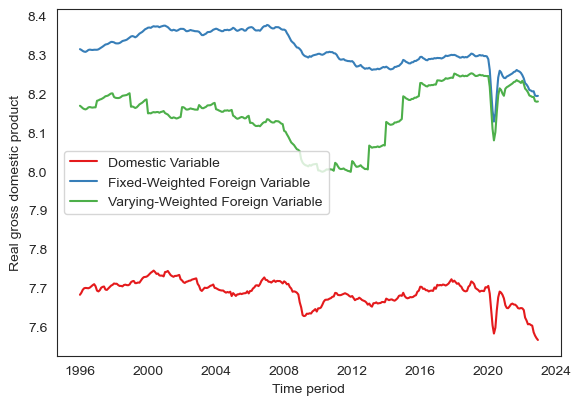

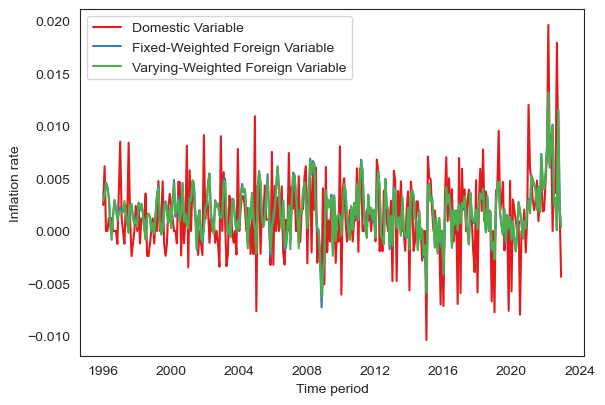

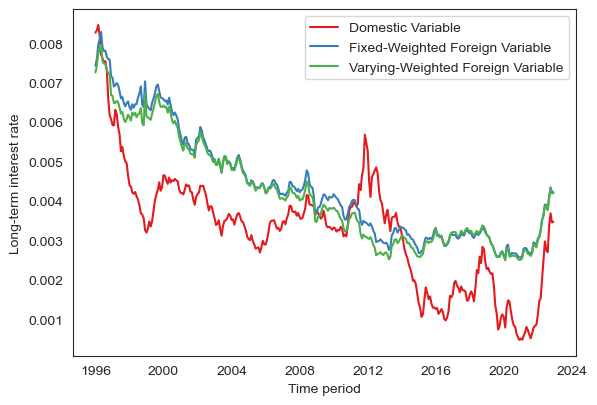

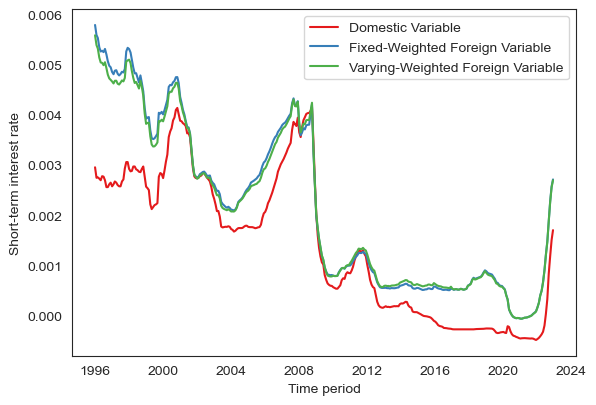

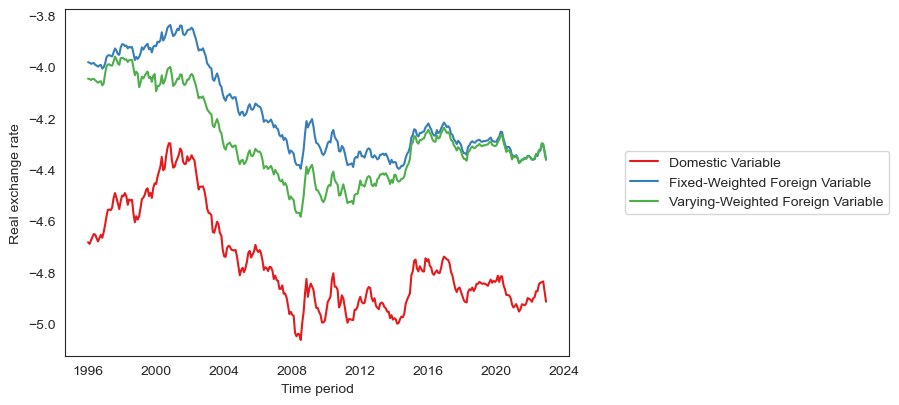

In [254]:
# Define a country
country = 'Germany'

sns.color_palette("Set1")

# Define the x_it and x_star for a country
x_it = df[country].T
x_star_fixed = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
x_star_vary = pd.concat([sum(df[foreign_country].T.loc[str(year)] * ((df_trade_year[year-1]+df_trade_year[year-2]+df_trade_year[year-3])/3).loc[country][foreign_country] for foreign_country in country_list) for year in year_list[3:]])

# Plot x_it and x_star for every variable
for i in range(len(variable_list)):
    fig, ax = plt.subplots()

    sns.lineplot(x_it[variable_list[i]],label='Domestic Variable')
    sns.lineplot(x_star_fixed[variable_list[i]],label='Fixed-Weighted Foreign Variable')
    sns.lineplot(x_star_vary[variable_list[i]],label='Varying-Weighted Foreign Variable')
    
    plt.xlabel("Time period")
    plt.ylabel(ext_variable_list[i])
    
    fig.set_size_inches(6.5, 4.5)

    if (i >= 4):
        pos = ax.get_position()
        ax.set_position([pos.x0, pos.y0, pos.width, pos.height])
        ax.legend(loc='center right', bbox_to_anchor=(1.65, 0.5))

    plt.show()

# Test order of integration

In [12]:
# Define the DataFrames to fill the results in
adf_test_lag0 = pd.DataFrame(index=variable_list)
adf_test_lag1 = pd.DataFrame(index=variable_list)
adf_test_lag2 = pd.DataFrame(index=variable_list)

# Loop over every country and variable
for country in country_list:
    for variable in variable_list:
        
        # Take the data and its first and second difference
        non_dif = df[country].loc[variable]
        first_dif = np.diff(non_dif)
        second_dif = np.diff(first_dif)
        
        # Fill the DataFrames with the adf test statistics
        adf_test_lag0.loc[variable,country] = round(sm.tsa.stattools.adfuller(non_dif, autolag= 'AIC')[0],4)
        adf_test_lag1.loc[variable,country] = round(sm.tsa.stattools.adfuller(first_dif, autolag= 'AIC')[0],4)
        adf_test_lag2.loc[variable,country] = round(sm.tsa.stattools.adfuller(second_dif, autolag= 'AIC')[0],4)

In [13]:
# Show the results

adf_test_lag0
# adf_test_lag1
# adf_test_lag2

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
GDP,-3.9972,0.1723,-3.1870,-2.0843,-0.7615,0.0668,-1.7600,-1.1241,-1.8749,0.9149,-1.0482,-0.1447,-1.8195
inf_rate,-2.3015,-8.8342,-3.4649,-2.0514,-0.9618,-0.7950,-2.6179,-3.8774,-3.6904,-4.5406,-3.2829,-1.3863,-3.9688
long_int,-2.1007,-2.0935,-1.8570,-1.8167,-3.5143,-3.0291,-1.9575,-1.6703,-2.8168,-2.3803,-1.9494,-1.5656,-2.2266
short_int,-2.1967,-1.9729,-2.3774,-1.8776,-1.9043,-2.5281,-1.9795,-2.3196,-1.6292,-2.4652,-2.9912,-1.6485,-2.5937
exch_rate,-1.0666,-1.5518,-1.3361,-1.3967,-1.3184,-1.3118,-2.2597,-1.5331,-0.9751,-2.5683,-1.1651,-2.2472,0.6752


# Determine the lag order

In [262]:
def determine_lag(x_it,x_star,max_lag=8):
    
    # Define the current lowest BIC value
    min_bic = 0

    # Loop over all possible combinations
    for lag_x_it in range(1,max_lag+1):
        for lag_x_star in range(1,max_lag+1):
            
            # Initialize a dataframe with the x_star values of lag 0
            df_country = pd.concat([x_star])
            df_country.columns += "_L0"
    
            # Loop over all lag_x_it values to add the lagged values of x_it to df_country
            for lag in range(1,lag_x_it+1):
                lagged_x_it = x_it.shift(lag)
                lagged_x_it.columns += "_L"+str(lag) 
                df_country = pd.concat([df_country,lagged_x_it], axis=1)
            
            # Loop over all lag_x_star values to add the lagged values of x_star to df_country
            for lag in range(1,lag_x_star+1):
                lagged_x_star = x_star.shift(lag)
                lagged_x_star.columns += "_L"+str(lag) 
                df_country = pd.concat([df_country,lagged_x_star], axis=1)
    
            # Create and fit the model
            model = VAR(endog = x_it.iloc[max_lag:], exog = df_country.iloc[max_lag:])
            results = model.fit(maxlags=0,trend='ct')
            
            # Determine the BIC value
            results_bic = -2 * results.llf / 5 + (2 + 5 * (lag_x_it+lag_x_star+1)) * np.log(324)
            
            # Update the lag and BIC value if the BIC value is smaller
            if (results_bic < min_bic):
                min_bic = results_bic
                best_lag_bic = (lag_x_it,lag_x_star)
    
    return best_lag_bic, min_bic

In [261]:
# Loop over all country to calculate the best lag order
for country in country_list:
    
    # Define x_it
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Run method to determine the lag order and its BIC value
    lag_results = determine_lag(x_it,x_star,max_lag=8)
    
    print("For",country)
    print("The lag order by BIC is",lag_results[0])
    print("The BIC value is",lag_results[1])
    print("")

For Australia
The lag order by BIC is (4, 1)
The BIC value is -3666.3300797128313

For Brazil
The lag order by BIC is (4, 4)
The BIC value is -2969.4487568714753

For Canada
The lag order by BIC is (4, 4)
The BIC value is -3458.2293922241797

For France
The lag order by BIC is (4, 4)
The BIC value is -3806.4925437028546

For Germany
The lag order by BIC is (4, 4)
The BIC value is -3531.97091074073

For Italy
The lag order by BIC is (4, 4)
The BIC value is -3720.9356583067847

For Japan
The lag order by BIC is (4, 1)
The BIC value is -3454.171341013792

For Korea
The lag order by BIC is (4, 1)
The BIC value is -3256.3208367156817

For New Zealand
The lag order by BIC is (4, 4)
The BIC value is -3553.371060352829

For South Africa
The lag order by BIC is (4, 4)
The BIC value is -3150.8560312836316

For Spain
The lag order by BIC is (4, 4)
The BIC value is -3728.0185722659303

For United Kingdom
The lag order by BIC is (3, 3)
The BIC value is -3265.4724086881697

For United States
The lag

In [263]:
# Loop over all country to calculate the best lag order
for country in country_list:
    
    # Define x_it
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with varying trade weights
    x_star = pd.concat([sum(df[foreign_country].T.loc[str(year)] * ((df_trade_year[year-1]+df_trade_year[year-2]+df_trade_year[year-3])/3).loc[country][foreign_country] for foreign_country in country_list) for year in year_list[3:]])
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Run method to determine the lag order and its BIC value
    lag_results = determine_lag(x_it,x_star,max_lag=8)
    
    print("For",country)
    print("The lag order by BIC is",lag_results[0])
    print("The BIC value is",lag_results[1])
    print("")

For Australia
The lag order by BIC is (4, 1)
The BIC value is -3658.158932609459

For Brazil
The lag order by BIC is (4, 1)
The BIC value is -2961.5420374423265

For Canada
The lag order by BIC is (4, 1)
The BIC value is -3405.7497736415667

For France
The lag order by BIC is (4, 1)
The BIC value is -3650.182283171451

For Germany
The lag order by BIC is (4, 1)
The BIC value is -3477.178834272809

For Italy
The lag order by BIC is (4, 1)
The BIC value is -3560.633953449189

For Japan
The lag order by BIC is (4, 1)
The BIC value is -3435.411510911684

For Korea
The lag order by BIC is (4, 1)
The BIC value is -3252.9509254502236

For New Zealand
The lag order by BIC is (4, 1)
The BIC value is -3530.615282551879

For South Africa
The lag order by BIC is (4, 1)
The BIC value is -3055.016551504776

For Spain
The lag order by BIC is (4, 1)
The BIC value is -3523.6087861037363

For United Kingdom
The lag order by BIC is (4, 1)
The BIC value is -3150.52786090468

For United States
The lag orde

# Checking weights

In [17]:
def fit_model(x_it,x_star,lag_x_it,lag_x_star):
    
    # Initialize a dataframe with the x_star values of lag 0
    df_country = pd.concat([x_star])
    df_country.columns += "_L0"
    
    # Loop over all lag_x_it values to add the lagged values of x_it to df_country
    for lag in range(1,lag_x_it+1):
        lagged_x_it = x_it.shift(lag)
        lagged_x_it.columns += "_L"+str(lag) 
        df_country = pd.concat([df_country,lagged_x_it], axis=1)
                
    # Loop over all lag_x_star values to add the lagged values of x_star to df_country
    for lag in range(1,lag_x_star+1):
        lagged_x_star = x_star.shift(lag)
        lagged_x_star.columns += "_L"+str(lag) 
        df_country = pd.concat([df_country,lagged_x_star], axis=1)
    
    # Create and fit the model
    model = VAR(endog = x_it.iloc[max_lag:], exog = df_country.iloc[max_lag:])
    results = model.fit(maxlags=0,trend='ct')
    
    return results

In [18]:
# Define the chosen lag
lag_x_it = 4
lag_x_star = 4
max_lag = max(lag_x_it,lag_x_star)

# Define a DataFrame for the R_squared
df_Rsquared_fixed = pd.DataFrame(index=variable_list)

# Loop over all countries
for country in country_list:
    
    # Define x_it
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Create and fit the model
    results = fit_model(x_it,x_star,lag_x_it,lag_x_star)

    # Calculate all R^2's of all variables
    for variable in variable_list:
        df_Rsquared_fixed.loc[variable,country] = skm.r2_score(results.fittedvalues[variable+"_x_it"]+results.resid[variable+"_x_it"],results.fittedvalues[variable+"_x_it"])

In [19]:
# Define the chosen lag
lag_x_it = 4
lag_x_star = 4
max_lag = max(lag_x_it,lag_x_star)

# Define a DataFrame for the R_squared
df_Rsquared_vary = pd.DataFrame(index=variable_list)

# Loop over all countries
for country in country_list:

    # Define x_it
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = pd.concat([sum(df[foreign_country].T.loc[str(year)] * ((df_trade_year[year-1]+df_trade_year[year-2]+df_trade_year[year-3])/3).loc[country][foreign_country] for foreign_country in country_list) for year in year_list[3:]])
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Create and fit the model
    results = fit_model(x_it,x_star,lag_x_it,lag_x_star)
    
    # Calculate all R^2's of all variables
    for variable in variable_list:
        df_Rsquared_vary.loc[variable,country] = skm.r2_score(results.fittedvalues[variable+"_x_it"]+results.resid[variable+"_x_it"],results.fittedvalues[variable+"_x_it"])

In [20]:
# Full DataFrame of R^2's
# df_Rsquared_fixed

# Mean of R^2's
np.mean(df_Rsquared_fixed,axis=1) 

GDP          0.997902
inf_rate     0.627599
long_int     0.989729
short_int    0.993408
exch_rate    0.991742
dtype: float64

In [21]:
# Full DataFrame of R^2's
# df_Rsquared_vary

# Mean of R^2's
np.mean(df_Rsquared_vary,axis=1) 

GDP          0.997198
inf_rate     0.623353
long_int     0.989607
short_int    0.993408
exch_rate    0.991375
dtype: float64

# Fitting the model

In [371]:
# Define the chosen lag
lag_x_it = 4
lag_x_star = 4
max_lag = max(lag_x_it,lag_x_star)

# Define two dictionaries for the parameter estimates and residuals
df_estimates = {}
resid_dict = {}

# Loop over all countries
for country in country_list:
    
    # Define x_it
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Create and fit the model
    results = fit_model(x_it,x_star,lag_x_it,lag_x_star)

    # Fill the parameter estimates of the VARX model in the dictionary
    df_estimates[country] = results.params[x_it.columns.tolist()].T

    # Fill the residuals of the VARX model in the dictionary
    resid_dict[country] = results.resid

In [372]:
# Example of the VARX estimates of Australia
df_estimates['Japan']

,const,trend,GDP_x_star_L0,inf_rate_x_star_L0,long_int_x_star_L0,short_int_x_star_L0,exch_rate_x_star_L0,GDP_x_it_L1,inf_rate_x_it_L1,long_int_x_it_L1,...,GDP_x_star_L3,inf_rate_x_star_L3,long_int_x_star_L3,short_int_x_star_L3,exch_rate_x_star_L3,GDP_x_star_L4,inf_rate_x_star_L4,long_int_x_star_L4,short_int_x_star_L4,exch_rate_x_star_L4
GDP_x_it,0.459107,8.401264e-06,0.931178,0.721937,-0.208989,-0.807658,-0.000700,3.355373,2.400113,-0.059515,...,-3.338323,-1.206014,-1.446731,3.981608,-0.008032,1.039557,0.000895,0.380479,-2.187207,0.024223
inf_rate_x_it,-0.350991,-1.043979e-05,-0.117762,0.030860,0.166679,0.905966,-0.005552,-0.348157,-0.397346,0.171169,...,0.912149,0.501850,1.519044,-2.548075,0.018785,-0.327274,-0.048479,-0.249131,1.385854,-0.025049
long_int_x_it,0.047110,3.777931e-07,-0.001312,0.020202,0.315614,0.599288,0.004276,-0.017984,-0.018696,1.105405,...,0.040461,0.014756,-0.282425,-0.114237,0.002578,-0.016075,-0.003178,0.174451,-0.099468,0.000042
short_int_x_it,-0.001970,-1.478501e-07,0.001515,0.001711,0.009355,-0.000693,-0.000186,0.000087,0.000810,-0.006865,...,-0.003760,-0.001201,-0.000184,0.018632,0.000050,0.001179,0.000264,0.002417,-0.003888,0.000045
exch_rate_x_it,1.814623,-1.806531e-05,1.342599,2.186272,15.249180,14.287869,0.394305,1.215807,1.229722,0.105939,...,-4.196085,-0.920367,-4.755100,-5.162950,-0.042741,1.173391,-0.395347,12.055509,19.642337,0.052334


# Stacking the GVAR model

In [373]:
# Defining lengths k_i, k_star and k:
k_i = k_star = len(variable_list)
k = len(variable_list) * len(country_list)

# Stack all a_i0 parameters
matrix_col = []
for country in country_list:
    matrix_col.append(df_estimates[country].loc[:,"const"])
a_0 = pd.concat(matrix_col)

# Stack all a_i1 parameters
matrix_col = []

for country in country_list:
    matrix_col.append(df_estimates[country].loc[:,"trend"])
a_1 = pd.concat(matrix_col)

# Stack all residuals
epsilon_t = pd.concat(resid_dict.values(), axis=1).T

In [374]:
def create_G_j(j):
    
    # Define an empty collection of matrices
    matrix_col = []

    # Loop over all countries
    for country in country_list:
        
        # Create Omega_i
        i = np.where(country_list == country)[0][0]
        E_i = np.hstack((np.zeros((k_i, i * k_i)), np.eye(k_i), np.zeros((k_i, (13-i-1) * k_i))))
        W_i = np.hstack([foreign_trade * np.eye(k_star) for foreign_trade in df_trade.loc[country]])
        Omega_i = np.vstack((E_i,W_i))
        
        # Create A_ij, depending on j
        if (j == 0):
            selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_star_L0")]
            
            lambda_i = df_estimates[country].loc[:,selected_cols]
            A_i = np.hstack((np.eye(k_i),-lambda_i))
        else:
            
            if (lag_x_it < j):
                print(j)
                phi_i = np.zeros((k_i,k_i))
            else:
                selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_it_L"+str(j))]
                phi_i = df_estimates[country].loc[:,selected_cols]

            if (lag_x_star < j):
                lambda_i = np.zeros((k_i,k_star))
            else:
                selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_star_L"+str(j))]
                lambda_i = df_estimates[country].loc[:,selected_cols]
            
            A_i = np.hstack((phi_i,lambda_i))
            
        # Finally, compute G_i by A_i and Omega_i
        G_i = A_i @ Omega_i
        matrix_col.append(G_i)
    
    # Return G_j
    return np.vstack(matrix_col)

In [375]:
# To show that this method works, we compute the residuals by matrices G:

# Create matrices G_j
G_0 = create_G_j(j=0)
G_1 = create_G_j(j=1)
G_2 = create_G_j(j=2)
G_3 = create_G_j(j=3)
G_4 = create_G_j(j=4)

# Function to get the x_t of time t and lag l
def x_t(l,t): 
    return pd.concat([df[country].T for country in country_list],axis=1).T.iloc[:,max_lag+t-l]

# Set time t between 0 and 319
t = 0

# The residuals of time t are the same as of the ones from the VARX* models
print(G_0 @ x_t(0,t) - a_0 - a_1 * (t+1) - G_1 @ x_t(1,t) -  G_2 @ x_t(2,t) - G_3 @ x_t(3,t) -  G_4 @ x_t(4,t))

GDP_x_it          0.000210
inf_rate_x_it    -0.000623
long_int_x_it     0.000060
short_int_x_it   -0.000024
exch_rate_x_it   -0.005686
                    ...   
GDP_x_it          0.001572
inf_rate_x_it    -0.002264
long_int_x_it     0.000131
short_int_x_it    0.000032
exch_rate_x_it    0.012362
Length: 65, dtype: float64


In [376]:
# Compare it with the residuals from the regression
epsilon_t

,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,1996-11-01,1996-12-01,1997-01-01,1997-02-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
GDP_x_it,0.000210,-0.000084,-0.000207,-0.000659,-0.000541,-0.000609,-0.001384,-0.000807,0.000562,0.000869,...,-0.000547,-0.001777,0.000541,0.000016,0.000475,-0.000330,-0.000530,0.000176,-0.000979,-0.000547
inf_rate_x_it,-0.000623,-0.000026,-0.000113,0.000142,-0.000214,-0.000178,0.000134,0.000441,-0.000118,0.000139,...,-0.000230,0.000627,-0.000062,0.000409,-0.000070,0.000157,0.000105,-0.000308,0.000176,0.000313
long_int_x_it,0.000060,0.000242,-0.000180,-0.000275,0.000083,-0.000192,-0.000107,0.000298,0.000107,0.000052,...,0.000057,0.000048,0.000196,0.000151,-0.000130,0.000136,0.000036,0.000145,0.000055,-0.000036
short_int_x_it,-0.000024,0.000035,0.000092,-0.000436,0.000248,-0.000099,0.000036,-0.000088,-0.000018,0.000194,...,-0.000083,-0.000043,0.000198,0.000268,0.000142,-0.000023,0.000187,-0.000025,0.000055,0.000005
exch_rate_x_it,-0.005686,0.001982,0.015239,0.018094,-0.006801,0.007211,-0.014253,-0.012065,0.005981,-0.020178,...,-0.022239,-0.014085,0.020289,-0.027419,0.002659,-0.022667,-0.007611,-0.003264,-0.030186,0.005207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GDP_x_it,0.001572,0.000754,-0.001057,-0.000274,-0.000993,-0.001548,0.000307,0.001895,0.001038,-0.000580,...,0.000726,0.004550,-0.001568,-0.003611,0.001781,-0.002453,-0.002273,0.001529,0.001718,-0.001824
inf_rate_x_it,-0.002264,-0.001301,0.000805,0.000272,0.001023,0.001377,-0.000480,-0.002107,-0.000595,0.000873,...,-0.001392,-0.004749,0.001831,0.004213,-0.001540,0.002794,0.002907,-0.001402,-0.001912,0.001304
long_int_x_it,0.000131,-0.000628,-0.000160,0.000065,-0.000172,0.000272,0.000062,-0.000096,-0.000174,-0.000586,...,0.000184,-0.000346,0.000100,0.000184,0.000206,-0.000201,-0.000047,-0.000180,-0.000060,0.000270
short_int_x_it,0.000032,-0.000004,0.000035,-0.000185,0.000208,0.000017,0.000093,0.000070,0.000130,0.000017,...,0.000109,-0.000108,0.000079,0.000074,0.000062,-0.000017,0.000008,0.000126,0.000268,-0.000187


In [377]:
# Calculate the inverse of G_0
G_0_inv = np.linalg.inv(create_G_j(j=0))

# Create a dictionary for the values of F_l
F_l_dict = {}

# Fill dictionary by computing the values of F_l 
for j in range(max_lag+1):
    F_l_dict[j] = G_0_inv @ create_G_j(j=j)

# GIRF

In [378]:
# Method to compute R_h for a given h
def calculate_R_h(h, memo={}):
    if h in memo:
        return memo[h]

    if h < 0:
        memo[h] = np.zeros((k,k))
    elif h == 0:
        memo[h] = np.eye(k)
    else:
        memo[h] = sum([F_l_dict[l] @ calculate_R_h(h-l) for l in range(1,max_lag+1)])
    
    return memo[h]

In [379]:
def perform_GIRF(max_h,country_shock,variable_shock,country_choice,variable_choice):
    
    # Get the index of the country and variable of the shock and define e_j
    country_i = np.where(country_list == country_shock)[0][0]
    variable_i = np.where(variable_list == variable_shock)[0][0]
    e_j = np.zeros((k,1))
    e_j[country_i * 5 + variable_i] = 1
    
    # Compute Sigma
    Sigma = np.cov(epsilon_t)

    # Initialize an empty array for the index and names of the chosen countries and variables
    index_array = []
    name_array = []
    
    
    # Loop over all chosen countries and variables and append to arrays
    for country in country_choice:
        country_i = np.where(country_list == country)[0][0]
        variable_i = np.where(variable_list == variable)[0][0]
        index_array.append(country_i * 5 + variable_i)
        name_array.append(country)
    
    # Calculate the GIRF for every h
    girf_matrix = np.hstack([calculate_R_h(h) @ G_0_inv @ Sigma @ e_j / np.sqrt(e_j.T @ Sigma @ e_j) for h in range(0,max_h+1)])
    
    country_color = {}
    country_line = {}

    for i in range(len(country_list)):
        country_color[country_list[i]] = ['#ff7f00','#377eb8','#377eb8', '#4daf4a', '#4daf4a', '#4daf4a','#984ea3','#984ea3', '#ff7f00', '#e41a1c', '#4daf4a',  '#4daf4a','#377eb8'][i]
        country_line[country_list[i]] = ['-','-','--','-','--',':','-','--','--','-','-.',(0, (5, 1)),':'][i]

    # Plot all GIRF in a plot
    for i in range(len(index_array)):
        sns.lineplot(x=np.arange(max_h+1),y=girf_matrix[index_array[i]], color=country_color[name_array[i]],linestyle=country_line[name_array[i]],label=name_array[i])
    plt.plot()

# Choose shock:
Countries: ['Australia' 'Brazil' 'Canada' 'France' 'Germany' 'Italy' 'Japan' 'Korea'
 'New Zealand' 'South Africa' 'Spain' 'United Kingdom' 'United States']
 
Variable: ['GDP', 'inf_rate', 'long_int', 'short_int', 'exch_rate']

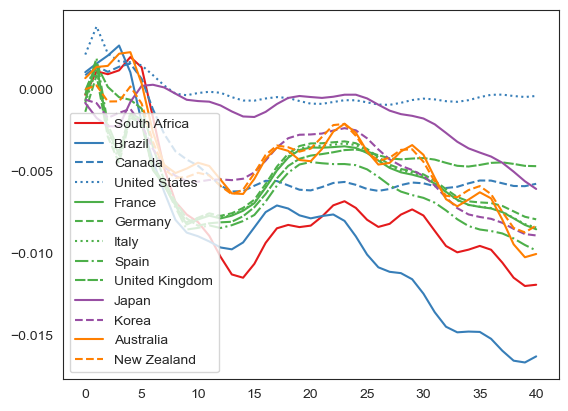

In [384]:
# Define the country and variable of the shock
country_shock = "United States"
variable_shock = 'GDP'

# Define the countries and variables that should be in the IRF
new_country_list = np.array(['South Africa','Brazil','Canada','United States','France','Germany','Italy','Spain','United Kingdom','Japan','Korea','Australia','New Zealand'])
country_choice = new_country_list
variable_choice = np.array(["short_int"])

# Define the length of h
max_h = 40
perform_GIRF(max_h,country_shock,variable_shock,country_choice,variable_choice)

# Period analysis

In [63]:
periods = 324
interval = np.arange(0,periods+1,periods / 2)

period_df = {}

for country in country_list:
    period_df[country] = df[country].iloc[:,int(interval[0]):int(interval[1])]

# Determine the lag order of a period

In [64]:
# Loop over all country to calculate the best lag order
for country in country_list:
    
    # Define x_it
    x_it = period_df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = sum(period_df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Run method to determine the lag order and its BIC value
    lag_results = determine_lag(x_it,x_star,max_lag=7)
    
    print("For",country)
    print("The lag order by BIC is",lag_results[0])
    print("The BIC value is",lag_results[1])
    print("")

For Australia
The lag order by BIC is (4, 1)
The BIC value is -1729.7031834358152

For Brazil
The lag order by BIC is (3, 1)
The BIC value is -1396.3847762968992

For Canada
The lag order by BIC is (4, 1)
The BIC value is -1678.4965300535825

For France
The lag order by BIC is (4, 1)
The BIC value is -1860.1593483845556

For Germany
The lag order by BIC is (4, 1)
The BIC value is -1713.3097153616343

For Italy
The lag order by BIC is (4, 1)
The BIC value is -1799.111421548446

For Japan
The lag order by BIC is (3, 1)
The BIC value is -1621.1244345446985

For Korea
The lag order by BIC is (3, 1)
The BIC value is -1484.7013484393717

For New Zealand
The lag order by BIC is (4, 1)
The BIC value is -1720.8341329865546

For South Africa
The lag order by BIC is (3, 1)
The BIC value is -1544.6419408947706

For Spain
The lag order by BIC is (3, 1)
The BIC value is -1834.5746010676373

For United Kingdom
The lag order by BIC is (4, 1)
The BIC value is -1595.7824194698317

For United States
The 

# Get GIRF

In [367]:
def create_G_j(j,df_estimates,lag_x_it,lag_x_star):
    
    # Define an empty collection of matrices
    matrix_col = []

    # Loop over all countries
    for country in country_list:
        
        # Create Omega_i
        i = np.where(country_list == country)[0][0]
        E_i = np.hstack((np.zeros((k_i, i * k_i)), np.eye(k_i), np.zeros((k_i, (13-i-1) * k_i))))
        W_i = np.hstack([foreign_trade * np.eye(k_star) for foreign_trade in df_trade.loc[country]])
        Omega_i = np.vstack((E_i,W_i))
        
        # Create A_ij, depending on j
        if (j == 0):
            selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_star_L0")]
            
            lambda_i = df_estimates[country].loc[:,selected_cols]
            A_i = np.hstack((np.eye(k_i),-lambda_i))
        else:
            
            if (lag_x_it < j):
                phi_i = np.zeros((k_i,k_i))
            else:
                selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_it_L"+str(j))]
                phi_i = df_estimates[country].loc[:,selected_cols]

            if (lag_x_star < j):
                lambda_i = np.zeros((k_i,k_star))
            else:
                selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_star_L"+str(j))]
                lambda_i = df_estimates[country].loc[:,selected_cols]
            
            A_i = np.hstack((phi_i,lambda_i))
            
        # Finally, compute G_i by A_i and Omega_i
        G_i = A_i @ Omega_i
        matrix_col.append(G_i)
    
    # Return G_j
    return np.vstack(matrix_col)

# Method to compute R_h for a given h
def calculate_R_h(h, memo={}):
    if h in memo:
        return memo[h]

    if h < 0:
        memo[h] = np.zeros((k,k))
    elif h == 0:
        memo[h] = np.eye(k)
    else:
        memo[h] = sum([F_l_dict[l] @ calculate_R_h(h-l) for l in range(1,max_lag+1)])
    
    return memo[h]    
    

def perform_quick_GIRF(period_df,lag_x_it,lag_x_star,max_h,country_shock,variable_shock,country_choice,variable_choice):
    max_lag = max(lag_x_it,lag_x_star)

    # Define two dictionaries for the parameter estimates and residuals
    df_estimates = {}
    resid_dict = {}

    # Loop over all countries
    for country in country_list:
    
        # Define x_it
        x_it = period_df[country].T
        x_it.index.freq = 'MS'
        x_it.columns = x_it.columns + "_x_it"
    
        # Define x_star with fixed trade weights
        x_star = sum(period_df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
        x_star.index.freq = 'MS'
        x_star.columns = x_star.columns + "_x_star"
    
        # Create and fit the model
        results = fit_model(x_it,x_star,lag_x_it,lag_x_star)

        # Fill the parameter estimates of the VARX model in the dictionary
        df_estimates[country] = results.params[x_it.columns.tolist()].T

        # Fill the residuals of the VARX model in the dictionary
        resid_dict[country] = results.resid
    
    # Defining lengths k_i, k_star and k:
    k_i = k_star = len(variable_list)
    k = len(variable_list) * len(country_list)

    # Stack all a_i0 parameters
    matrix_col = []
    for country in country_list:
        matrix_col.append(df_estimates[country].loc[:,"const"])
    a_0 = pd.concat(matrix_col)

    # Stack all a_i1 parameters
    matrix_col = []

    for country in country_list:
        matrix_col.append(df_estimates[country].loc[:,"trend"])
    a_1 = pd.concat(matrix_col)

    # Stack all residuals
    epsilon_t = pd.concat(resid_dict.values(), axis=1).T

    # Calculate the inverse of G_0
    G_0_inv = np.linalg.inv(create_G_j(0,df_estimates,lag_x_it,lag_x_star))

    # Create a dictionary for the values of F_l
    F_l_dict = {}

    # Fill dictionary by computing the values of F_l 
    for j in range(max_lag+1):
        F_l_dict[j] = G_0_inv @ create_G_j(j,df_estimates,lag_x_it,lag_x_star)
        
    # Get the index of the country and variable of the shock and define e_j
    country_i = np.where(country_list == country_shock)[0][0]
    variable_i = np.where(variable_list == variable_shock)[0][0]
    e_j = np.zeros((k,1))
    e_j[country_i * 5 + variable_i] = -1
    
    # Compute Sigma
    Sigma = np.cov(epsilon_t)

    # Initialize an empty array for the index and names of the chosen countries and variables
    index_array = []
    name_array = []
    
    # Loop over all chosen countries and variables and append to arrays
    for variable in variable_choice:
        for country in country_choice:
            country_i = np.where(country_list == country)[0][0]
            variable_i = np.where(variable_list == variable)[0][0]
            index_array.append(country_i * 5 + variable_i)
            name_array.append(country[:3]+" "+variable)
    
    # Calculate the GIRF for every h
    girf_matrix = np.hstack([calculate_R_h(h) @ G_0_inv @ Sigma @ e_j / np.sqrt(e_j.T @ Sigma @ e_j) for h in range(0,max_h+1)])

    # Plot all GIRF in a plot
    for i in range(len(index_array)):
        sns.lineplot(x=np.arange(max_h+1),y=girf_matrix[index_array[i]], label=name_array[i])
    plt.plot()

In [370]:
periods = 324
interval = np.arange(0,periods+1,periods / 2)

period_df = {}
period = 1

for country in country_list:
    period_df[country] = df[country].iloc[:,int(interval[period]):int(interval[period+1])]

# Define the data and chosen lags
lag_x_it = 4
lag_x_star = 4

# Define the country and variable of the shock
country_shock = "United States"
variable_shock = 'GDP'

# Define the countries and variables that should be in the IRF
country_choice = country_list#np.array(["France","Germany","Italy"])
variable_choice = np.array(["short_int"])

# Define the length of h
max_h = 1

perform_quick_GIRF(period_df,lag_x_it,lag_x_star,max_h,country_shock,variable_shock,country_choice,variable_choice)

MissingDataError: exog contains inf or nans

# VECM

In [401]:
def perform_VECM(period_df):
    # Define the chosen lag
    lag_x_it = 4
    lag_x_star = 1
    max_lag = max(lag_x_it,lag_x_star)

    # Loop over all countries
    for country in ['United States']:
    
        # Define x_it
        x_it = period_df[country].T
        x_it.index.freq = 'MS'
        x_it.columns = x_it.columns + "_x_it"
    
        # Define x_star with fixed trade weights
        x_star = sum(period_df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
        x_star.index.freq = 'MS'
        x_star.columns = x_star.columns + "_x_star"
    
    
        # Initialize a dataframe with the x_star values of lag 0
        df_country = pd.concat([-x_it.shift(1),-x_star.shift(1)],axis=1)
        df_country.columns += "_L1"
    
        x_star_diff = x_star.diff(1)
        x_star_diff.columns += "_diff_L0" 
        df_country = pd.concat([df_country,x_star_diff], axis=1)

        # Loop over all lag_x_it values to add the lagged values of x_it to df_country
        for lag in range(1,max_lag+1):
            if (lag <= lag_x_it-1):
                lagged_x_it = x_it.diff(1).shift(lag)
                lagged_x_it.columns += "_diff_L"+str(lag) 
                df_country = pd.concat([df_country,lagged_x_it], axis=1)
        
            if (lag <= lag_x_star-1):
                lagged_x_star = x_star.diff(1).shift(lag)
                lagged_x_star.columns += "_diff_L"+str(lag) 
                df_country = pd.concat([df_country,lagged_x_star], axis=1)
    
        # Create and fit the model
        model = VAR(endog = x_it.diff(1).iloc[max_lag:], exog = df_country.iloc[max_lag:])
        results = model.fit(maxlags=0,trend='ct',method='ols')
    
        return results.params.T

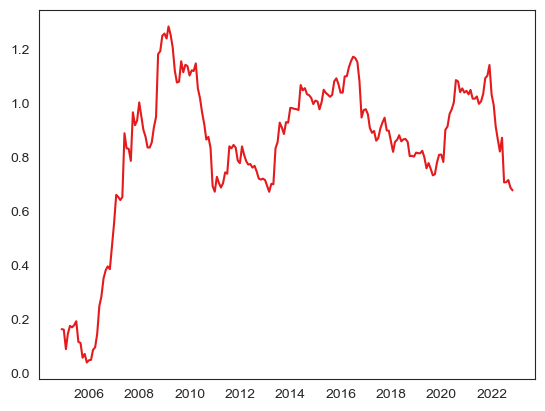

In [361]:
periods = 324
period_len = 108
steps = 1

period_df = {}
time = 0


params = []
year = []

for time in np.arange(0,periods-period_len,steps):
#     print(time)
    for country in country_list:
        period_df[country] = df[country].iloc[:,time:period_len+time]
    
    year.append(period_df[country].columns[-1])
    
    params.append(perform_VECM(period_df))
    
sns.lineplot(x=year,y=params)
plt.show()

In [402]:
df_estimates['United States']

,const,trend,GDP_x_star_L0,inf_rate_x_star_L0,long_int_x_star_L0,short_int_x_star_L0,exch_rate_x_star_L0,GDP_x_it_L1,inf_rate_x_it_L1,long_int_x_it_L1,...,GDP_x_it_L4,inf_rate_x_it_L4,long_int_x_it_L4,short_int_x_it_L4,exch_rate_x_it_L4,GDP_x_star_L1,inf_rate_x_star_L1,long_int_x_star_L1,short_int_x_star_L1,exch_rate_x_star_L1
GDP_x_it,0.212859,-3.036896e-05,0.216366,-0.742238,-0.750529,0.413877,0.014631,2.538306,1.486481,0.431159,...,-0.687098,-0.041629,0.097601,0.613338,-0.000221,-0.174268,-0.352836,-0.463583,0.145719,-0.006223
inf_rate_x_it,-0.037889,3.663851e-05,0.043116,1.037440,0.884068,0.029444,-0.021196,-0.112167,-0.072247,-0.157838,...,0.182974,0.044344,-0.062663,-1.169213,0.007495,-0.098376,0.312451,-0.026506,-0.431739,0.013254
long_int_x_it,0.046569,7.570907e-06,-0.018265,-0.010332,0.520683,-0.070942,0.003358,0.026949,0.042503,1.096402,...,-0.003310,0.003782,-0.131510,0.098701,-0.001937,0.016039,-0.015372,-0.403659,0.058651,-0.003068
short_int_x_it,-0.007607,-1.459927e-08,-0.003471,-0.000158,0.028952,0.496923,0.001694,0.023261,0.027927,-0.031312,...,-0.011062,-0.005152,-0.056576,-0.047284,-0.000812,0.000493,-0.003342,0.058165,-0.498025,-0.001878
exch_rate_x_it,-1.531801,-5.606340e-04,-0.486836,-1.020334,1.898608,-2.088437,0.068019,0.896684,-0.625649,-0.644737,...,-0.586934,-0.130135,-0.241808,1.057041,0.138201,0.461725,-0.385923,-4.742793,-1.779624,-0.055407


In [403]:
def fit_model(x_it,x_star,lag_x_it,lag_x_star):
    
    # Initialize a dataframe with the x_star values of lag 0
    df_country = pd.concat([x_star])
    df_country.columns += "_L0"
    
    # Loop over all lag_x_it values to add the lagged values of x_it to df_country
    for lag in range(1,lag_x_it+1):
        lagged_x_it = x_it.shift(lag)
        lagged_x_it.columns += "_L"+str(lag) 
        df_country = pd.concat([df_country,lagged_x_it], axis=1)
                
    # Loop over all lag_x_star values to add the lagged values of x_star to df_country
    for lag in range(1,lag_x_star+1):
        lagged_x_star = x_star.shift(lag)
        lagged_x_star.columns += "_L"+str(lag) 
        df_country = pd.concat([df_country,lagged_x_star], axis=1)
    
    # Create and fit the model
    model = VAR(endog = x_it.iloc[max_lag:], exog = df_country.iloc[max_lag:])
    results = model.fit(maxlags=0,trend='ct')
    
    return results

In [404]:
# Define the chosen lag
lag_x_it = 4
lag_x_star = 1
max_lag = max(lag_x_it,lag_x_star)

# Define two dictionaries for the parameter estimates and residuals
df_estimates = {}
resid_dict = {}

# Loop over all countries
for country in country_list:
    
    # Define x_it
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Create and fit the model
    results = fit_model(x_it,x_star,lag_x_it,lag_x_star)

    # Fill the parameter estimates of the VARX model in the dictionary
    df_estimates[country] = results.params[x_it.columns.tolist()].T

    # Fill the residuals of the VARX model in the dictionary
    resid_dict[country] = results.resid
    
df_estimates["Australia"]

,const,trend,GDP_x_star_L0,inf_rate_x_star_L0,long_int_x_star_L0,short_int_x_star_L0,exch_rate_x_star_L0,GDP_x_it_L1,inf_rate_x_it_L1,long_int_x_it_L1,...,GDP_x_it_L4,inf_rate_x_it_L4,long_int_x_it_L4,short_int_x_it_L4,exch_rate_x_it_L4,GDP_x_star_L1,inf_rate_x_star_L1,long_int_x_star_L1,short_int_x_star_L1,exch_rate_x_star_L1
GDP_x_it,0.136563,-1.546901e-06,0.060812,0.050977,-0.023569,0.369045,-0.004180,2.960455,-0.124169,0.136317,...,-0.702110,0.303425,-0.068223,0.030288,0.001559,-0.062482,-0.034075,-0.292858,-0.162137,0.005366
inf_rate_x_it,0.003491,4.250778e-06,0.018477,0.026414,0.146608,0.205481,-0.000090,-0.011487,2.467458,-0.019491,...,0.012571,-0.554577,0.188940,0.041040,-0.000656,-0.021871,0.022678,-0.119349,-0.275769,0.000032
long_int_x_it,-0.008443,-6.585801e-07,0.004193,0.005891,0.677033,-0.449581,0.000536,0.008856,0.019989,1.003321,...,-0.016168,0.006239,-0.030048,0.071744,0.000069,-0.003423,0.004810,-0.617832,0.393396,-0.000383
short_int_x_it,-0.015251,-9.291907e-07,0.003064,0.003421,0.034271,0.117964,0.000133,0.006038,0.010895,0.088623,...,0.001388,0.006654,0.006420,-0.202729,-0.000190,-0.002862,-0.002016,-0.054134,-0.086328,0.000108
exch_rate_x_it,-2.103839,3.446179e-05,-0.857021,-1.527842,-15.423375,-3.585107,0.919549,-1.577389,-7.379803,-8.136127,...,2.815752,1.844124,8.984383,4.617155,-0.044380,0.896035,0.107133,24.530096,-1.718988,-0.753536


In [405]:
perform_VECM(df)['GDP_x_star_diff_L0']

GDP_x_it          0.216366
inf_rate_x_it     0.043116
long_int_x_it    -0.018265
short_int_x_it   -0.003471
exch_rate_x_it   -0.486836
Name: GDP_x_star_diff_L0, dtype: float64

In [407]:
# Define the chosen lag
lag_x_it = 4
lag_x_star = 1
max_lag = max(lag_x_it,lag_x_star)

# Loop over all countries
for country in ['United States']:
    
    # Define x_it
    x_it = period_df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = sum(period_df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Initialize a dataframe with the x_star values of lag 0
    df_country = pd.concat([-x_it.shift(1),-x_star.shift(1)],axis=1)
    df_country.columns += "_L1"
    
    x_it_diff = x_it.shift(1)
    x_it_diff.columns += "_L1" 
    df_country = pd.concat([df_country,-x_it_diff], axis=1)
    
    x_star_diff = x_star.diff(1)
    x_star_diff.columns += "_diff_L0" 
    df_country = pd.concat([df_country,x_star_diff], axis=1)

    # Loop over all lag_x_it values to add the lagged values of x_it to df_country
    for lag in range(1,max_lag+1):
        if (lag <= lag_x_it-1):
            lagged_x_it = x_it.diff(1).shift(lag)
            lagged_x_it.columns += "_diff_L"+str(lag) 
            df_country = pd.concat([df_country,lagged_x_it], axis=1)
        
        if (lag <= lag_x_star-1):
            lagged_x_star = x_star.diff(1).shift(lag)
            lagged_x_star.columns += "_diff_L"+str(lag) 
            df_country = pd.concat([df_country,lagged_x_star], axis=1)
    
    # Create and fit the model
    model = VAR(endog = x_it.iloc[max_lag:], exog = df_country.iloc[max_lag:])
    results = model.fit(maxlags=0,trend='ct',method='ols')
    
results.params.T

,const,trend,GDP_x_it_L1,inf_rate_x_it_L1,long_int_x_it_L1,short_int_x_it_L1,exch_rate_x_it_L1,GDP_x_star_L1,inf_rate_x_star_L1,long_int_x_star_L1,...,GDP_x_it_diff_L2,inf_rate_x_it_diff_L2,long_int_x_it_diff_L2,short_int_x_it_diff_L2,exch_rate_x_it_diff_L2,GDP_x_it_diff_L3,inf_rate_x_it_diff_L3,long_int_x_it_diff_L3,short_int_x_it_diff_L3,exch_rate_x_it_diff_L3
GDP_x_it,0.656630,-0.000027,-0.430966,-0.199387,-0.562490,-0.422447,0.000093,-0.083546,0.751463,2.409890,...,-1.306827,-0.487270,-0.492090,2.168408,-0.011544,0.636608,0.115479,-1.263173,2.753463,-0.015452
inf_rate_x_it,-0.341029,0.000019,-0.053021,-0.016102,0.277289,0.160826,-0.007606,0.078449,-1.251383,-0.302511,...,0.251775,0.096936,1.104393,-0.224986,-0.000887,-0.256843,-0.106672,1.617508,3.033125,0.006099
long_int_x_it,0.060753,0.000014,0.002712,-0.020281,-0.388405,0.018486,-0.001993,-0.001986,0.037510,-0.376959,...,0.005671,0.004019,-0.189309,-0.610274,0.000556,-0.005190,-0.007838,0.026358,-0.204763,0.001834
short_int_x_it,0.011630,0.000005,0.000917,-0.002123,0.012445,-0.472910,-0.000645,-0.001620,-0.002430,-0.108980,...,-0.001746,-0.004879,-0.046392,-0.211853,-0.000591,0.002464,-0.001859,-0.026462,0.089784,0.000153
exch_rate_x_it,-3.819086,-0.001039,-0.126221,0.692789,1.277857,-2.472629,-0.210915,0.121310,0.961947,-1.903668,...,-0.149452,-0.115814,-1.223025,-6.455992,-0.143568,0.251275,0.095101,1.854478,15.485092,-0.044699


In [408]:
# Define the chosen lag
lag_x_it = 4
lag_x_star = 1
max_lag = max(lag_x_it,lag_x_star)

# Loop over all countries
for country in ['United States']:
    
    # Define x_it
    x_it = period_df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = sum(period_df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Initialize a dataframe with the x_star values of lag 0
    df_country = pd.concat([-x_it.shift(1),-x_star.shift(1)],axis=1)
    df_country.columns += "_L1"
    
    x_star_diff = x_star.diff(1)
    x_star_diff.columns += "_diff_L0" 
    df_country = pd.concat([df_country,x_star_diff], axis=1)

    # Loop over all lag_x_it values to add the lagged values of x_it to df_country
    for lag in range(1,max_lag+1):
        if (lag <= lag_x_it-1):
            lagged_x_it = x_it.diff(1).shift(lag)
            lagged_x_it.columns += "_diff_L"+str(lag) 
            df_country = pd.concat([df_country,lagged_x_it], axis=1)
        
        if (lag <= lag_x_star-1):
            lagged_x_star = x_star.diff(1).shift(lag)
            lagged_x_star.columns += "_diff_L"+str(lag) 
            df_country = pd.concat([df_country,lagged_x_star], axis=1)
    
    # Create and fit the model
    model = VAR(endog = x_it.diff(1).iloc[max_lag:], exog = df_country.iloc[max_lag:])
    results = model.fit(maxlags=0,trend='ct',method='ols')
    
results.params.T

,const,trend,GDP_x_it_L1,inf_rate_x_it_L1,long_int_x_it_L1,short_int_x_it_L1,exch_rate_x_it_L1,GDP_x_star_L1,inf_rate_x_star_L1,long_int_x_star_L1,...,GDP_x_it_diff_L2,inf_rate_x_it_diff_L2,long_int_x_it_diff_L2,short_int_x_it_diff_L2,exch_rate_x_it_diff_L2,GDP_x_it_diff_L3,inf_rate_x_it_diff_L3,long_int_x_it_diff_L3,short_int_x_it_diff_L3,exch_rate_x_it_diff_L3
GDP_x_it,0.656630,-0.000027,0.138068,-0.398773,-1.124980,-0.844893,0.000186,-0.083546,0.751463,2.409890,...,-1.306827,-0.487270,-0.492090,2.168408,-0.011544,0.636608,0.115479,-1.263173,2.753463,-0.015452
inf_rate_x_it,-0.341029,0.000019,-0.106042,0.967796,0.554578,0.321652,-0.015212,0.078449,-1.251383,-0.302511,...,0.251775,0.096936,1.104393,-0.224986,-0.000887,-0.256843,-0.106672,1.617508,3.033125,0.006099
long_int_x_it,0.060753,0.000014,0.005424,-0.040562,0.223190,0.036972,-0.003987,-0.001986,0.037510,-0.376959,...,0.005671,0.004019,-0.189309,-0.610274,0.000556,-0.005190,-0.007838,0.026358,-0.204763,0.001834
short_int_x_it,0.011630,0.000005,0.001835,-0.004247,0.024890,0.054180,-0.001290,-0.001620,-0.002430,-0.108980,...,-0.001746,-0.004879,-0.046392,-0.211853,-0.000591,0.002464,-0.001859,-0.026462,0.089784,0.000153
exch_rate_x_it,-3.819086,-0.001039,-0.252442,1.385579,2.555714,-4.945258,0.578170,0.121310,0.961947,-1.903668,...,-0.149452,-0.115814,-1.223025,-6.455992,-0.143568,0.251275,0.095101,1.854478,15.485092,-0.044699
